# Zero-Shot Object Detection with Grounding DINO

---

Grounding DINO can detect **arbitrary objects** with human inputs such as category names or referring expressions. The key solution of open-set object detection is introducing language to a closed-set detector DINO. for open-set concept generalization. If you want to learn more visit official GitHub [repository](https://github.com/IDEA-Research/GroundingDINO) and read the [paper](https://arxiv.org/abs/2303.05499).

![grounding dino figure](https://media.roboflow.com/notebooks/examples/grounding-dino-figure.png)


## Check GPU & Install Grounding DINO 🦕 

In [3]:
!nvidia-smi

Wed May 24 11:14:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.01       Driver Version: 516.01       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   43C    P0    35W /  N/A |      0MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import os
import supervision as sv
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from onemetric.cv.object_detection import MeanAveragePrecision
import cv2

HOME = os.getcwd()
HOME = os.path.abspath(os.path.join(HOME, os.pardir))
print(HOME)

f:\SS23\DILAB_project\SS2023_DI-Lab_Precitaste


In [3]:
## colab:
# %cd {HOME}
# !git clone https://github.com/IDEA-Research/GroundingDINO.git
# %cd {HOME}/GroundingDINO
# !pip install -q -e .

f:\SS23\DILAB_project\SS2023_DI-Lab_Precitaste
f:\SS23\DILAB_project\SS2023_DI-Lab_Precitaste\GroundingDINO


Cloning into 'GroundingDINO'...


^C


In [2]:
## set config path

import os

CONFIG_PATH = os.path.join(HOME, "external/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

f:\SS23\DILAB_project\SS2023_DI-Lab_Precitaste\external/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


## Get Weights

In [3]:
## local:

WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH = os.path.join(HOME, "external/GroundingDINO/weights", WEIGHTS_NAME)
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

## colab:

# %cd {HOME}
# !mkdir {HOME}/weights
# %cd {HOME}/weights
# !wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

# import os
# WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
# WEIGHTS_PATH = os.path.join(HOME, "weights", WEIGHTS_NAME)
# print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

f:\SS23\DILAB_project\SS2023_DI-Lab_Precitaste\external/GroundingDINO/weights\groundingdino_swint_ogc.pth ; exist: True


In [ ]:
# download example data

# %cd {HOME}
# !mkdir {HOME}/data
# %cd {HOME}/data

# !wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg
# !wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
# !wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg
# !wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg

/content
/content/data


## Load Dataset ##


f:\SS23\DILAB_project\SS2023_DI-Lab_Precitaste
Number of images:  6000


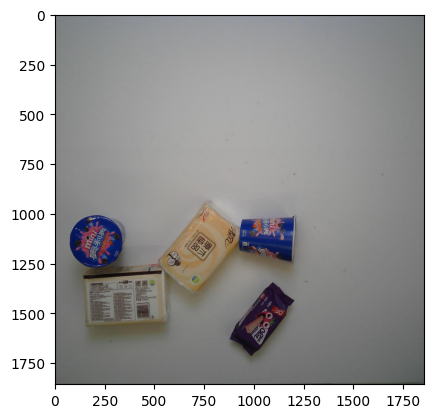

In [4]:
%cd {HOME}
from dataset.RPCDataset import RPCDataset
# The parent directory is the path of the folder that named as "retail_product_checkout"
# The script also downloads some json files in the same directory as itself
# However this jsons are not important, the main directory is the folder
dataset_parent_dir = os.path.join(HOME, "RPCdataset/retail_product_checkout")
# Split can be either train, val or test
dataset = RPCDataset(dataset_parent_dir, "val")

n_imgs = dataset.get_num_imgs()
print("Number of images: ", n_imgs)

import random
rand_ind = random.randint(0, n_imgs)
rand_img_path = dataset.get_img_path_by_id(rand_ind)

import matplotlib.pyplot as plt
# import cv2 
rand_img = dataset.get_img_by_id(rand_ind)

plt.figure()
plt.imshow(rand_img)
plt.show()

In [8]:
annots = dataset.get_annots_by_img_id(rand_ind, "sku_class")    # ==> list of tuples
print(list(set([annotation[1] for annotation in annots])))
# print([annotation[1] for annotation in annots])
test = list(set([annotation[1] for annotation in annots]))
test_str = ','.join(test)
print(test_str)

['personal_hygiene', 'seasoner', 'tissue', 'dessert', 'alcohol']
personal_hygiene,seasoner,tissue,dessert,alcohol


In [7]:
annots = dataset.get_annots_by_img_id(0, "sku_class")
print([annotation[1] for annotation in annots])
print([annotation[0] for annotation in annots])

['alcohol', 'canned_food', 'drink', 'drink']
[[519.44, 965.19, 405.05, 360.37], [282.17, 962.21, 278.97, 346.48], [477.74, 1181.62, 236.28, 360.37], [726.93, 1245.15, 343.5, 254.15]]


Bbox:  [797.4, 453.37, 427.85, 332.77]  belongs to class:  tissue
Bbox:  [1087.64, 803.66, 172.64, 285.23]  belongs to class:  personal_hygiene
Bbox:  [1252.77, 836.18, 350.29, 440.36]  belongs to class:  seasoner
Bbox:  [829.93, 1121.42, 295.24, 212.67]  belongs to class:  alcohol
Bbox:  [522.18, 1316.58, 375.31, 220.18]  belongs to class:  dessert
Bbox:  [79.32, 1221.5, 465.38, 432.85]  belongs to class:  dessert
Bbox:  [302.0, 916.25, 265.22, 185.15]  belongs to class:  tissue
Bbox:  [305.29, 660.23, 223.92, 171.51]  belongs to class:  tissue
Bbox:  [319.59, 226.68, 371.61, 471.66]  belongs to class:  tissue
Bbox:  [452.99, 1050.9, 204.86, 204.86]  belongs to class:  tissue
Bbox:  [624.5, 984.2, 228.68, 252.51]  belongs to class:  personal_hygiene
Bbox:  [877.0, 1303.4, 314.44, 390.67]  belongs to class:  seasoner
Bbox:  [877.0, 950.85, 271.56, 171.51]  belongs to class:  personal_hygiene
Bbox:  [1115.22, 1208.12, 376.38, 323.97]  belongs to class:  seasoner


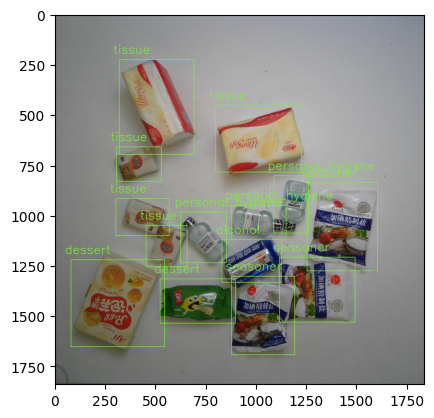

In [9]:
import cv2
annots = dataset.get_annots_by_img_id(rand_ind, 'sku_class')
for bbox, class_name in annots:
  print("Bbox: ", bbox, " belongs to class: ", class_name)

def vis_bbox_on_img(img, bbox, text):
  font = cv2.FONT_HERSHEY_SIMPLEX
  fontScale = 2
  thickness = 2

  x,y,w,h = [int(i) for i in bbox]
  paint_img = img.copy()
  
  text_x = max(30, x-30)
  text_y = max(30, y-30)

  cv2.rectangle(paint_img, (x, y), (x+w, y+h), (124, 241, 54), thickness)
  cv2.putText(paint_img, text, (text_x, text_y), font, fontScale, (124, 241, 54), thickness, cv2.LINE_AA)
  return paint_img

vised_img = rand_img.copy()
for annot in annots:
  vised_img = vis_bbox_on_img(vised_img, annot[0], annot[1])  


plt.figure()
plt.imshow(vised_img)
plt.show()  

## Load Grounding DINO Model

In [5]:

%cd {HOME}/external/GroundingDINO

from groundingdino.util.inference import load_model, load_image, predict, annotate
# , predict_with_classes

model = load_model(CONFIG_PATH, WEIGHTS_PATH)

f:\SS23\DILAB_project\SS2023_DI-Lab_Precitaste\external\GroundingDINO


f:\ANACONDA\envs\dilab\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
f:\ANACONDA\envs\dilab\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


f:\ANACONDA\envs\dilab\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\coral\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_

## Grounding DINO Demo

f:\ANACONDA\envs\dilab\lib\site-packages\transformers\modeling_utils.py:866: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
f:\ANACONDA\envs\dilab\lib\site-packages\torch\utils\checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


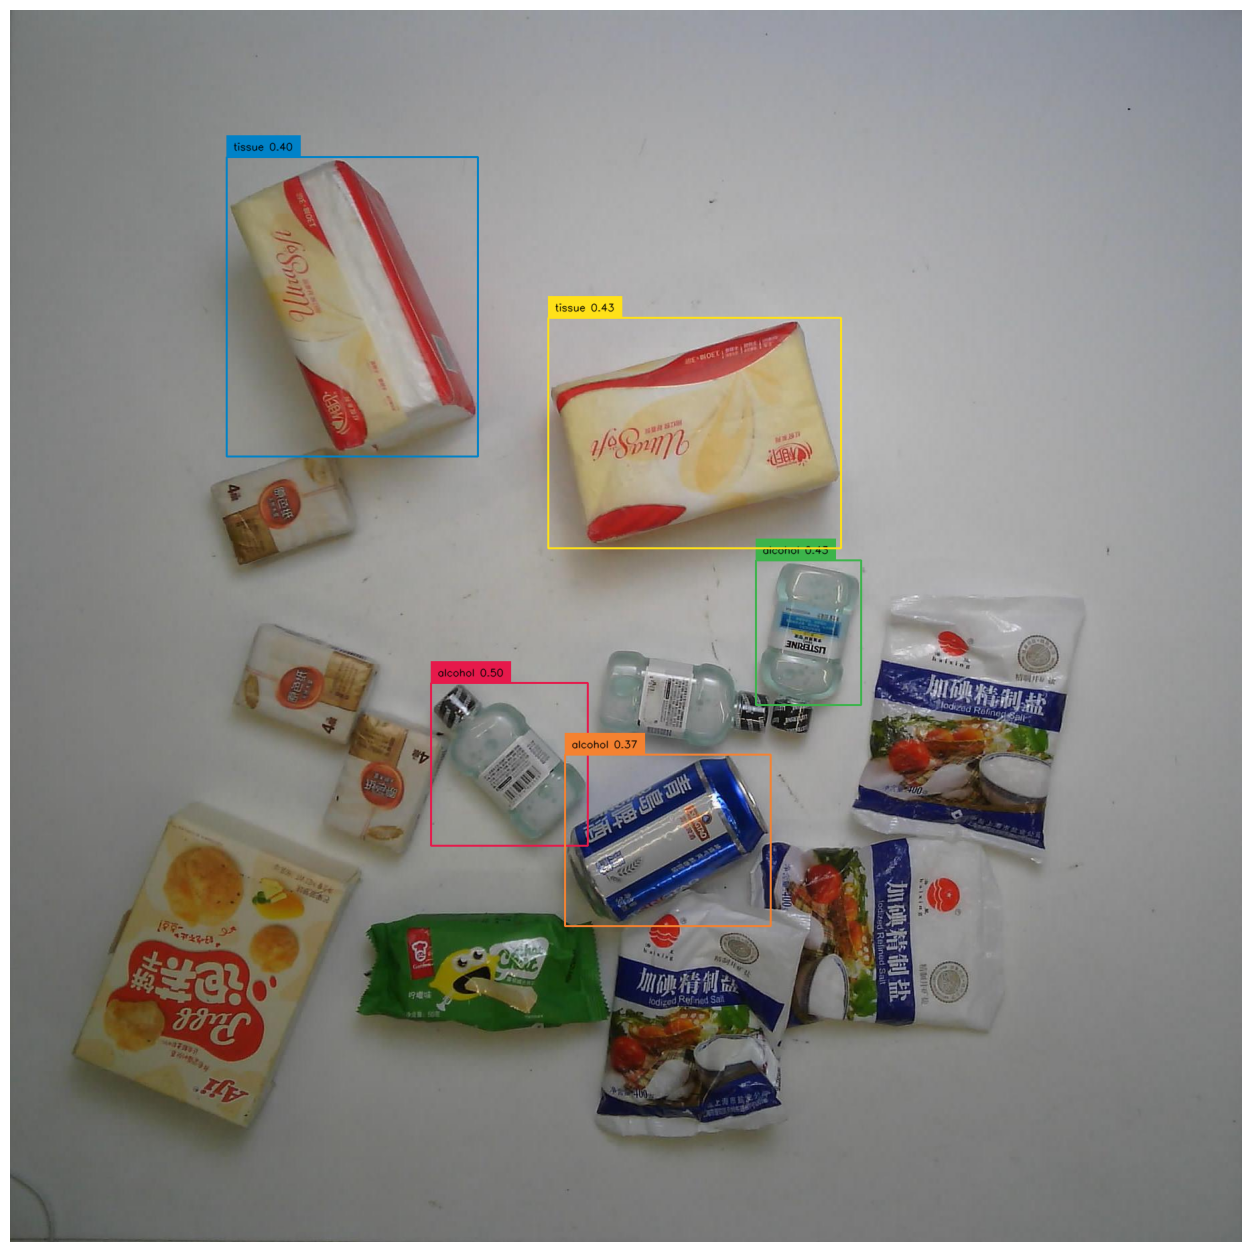

In [12]:
import os
import supervision as sv

# IMAGE_NAME = "dog-3.jpeg"
# IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

# TEXT_PROMPT = "puffed food in pink packaging, cup noodles with a dark blue background color, toothpaste"
TEXT_PROMPT = 'seasoner, tissue, alcohol, snacks'
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

# image_source, image = load_image(IMAGE_PATH)
image_source, image = load_image(rand_img_path)

boxes, logits, phrases = predict(
    model=model, 
    image=image, 
    caption=TEXT_PROMPT, 
    box_threshold=BOX_TRESHOLD, 
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

%matplotlib inline  
sv.plot_image(annotated_frame, (16, 16))

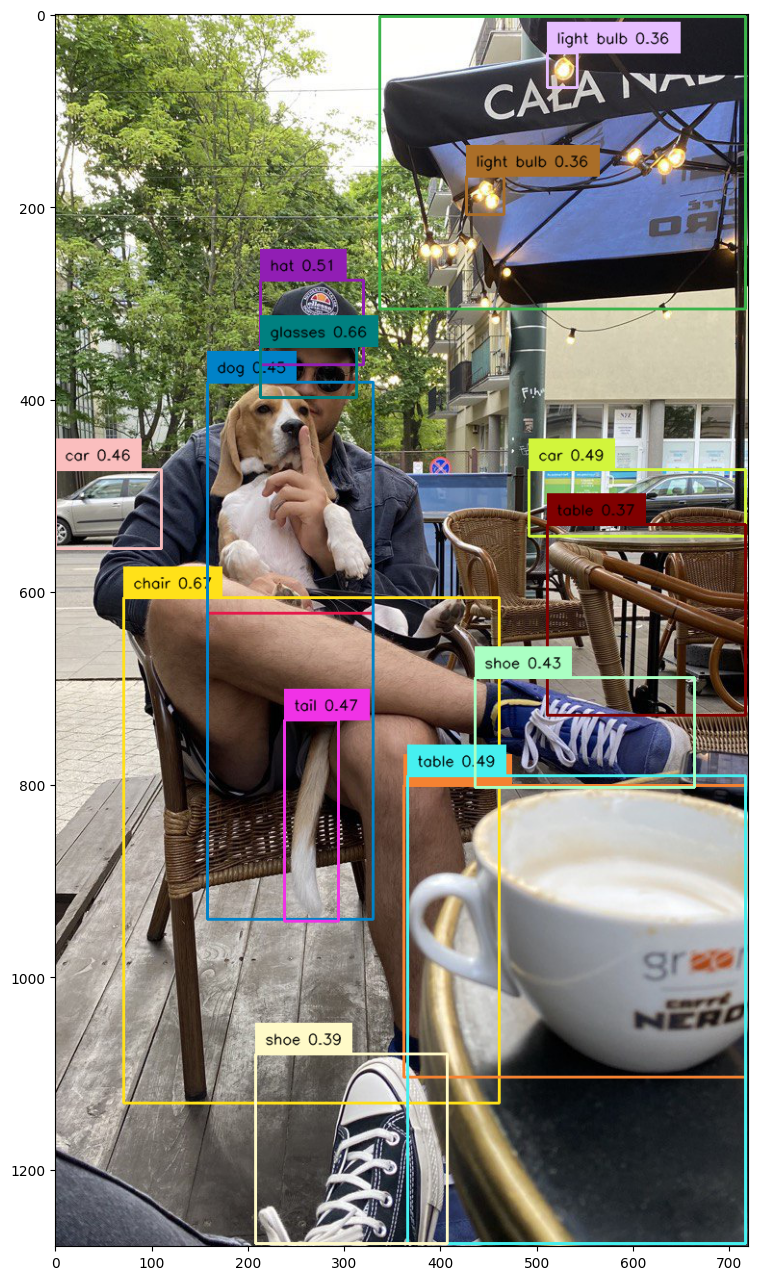

In [ ]:
# import os
# import supervision as sv

# IMAGE_NAME = "dog-3.jpeg"
# IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

# TEXT_PROMPT = "chair, dog, table, shoe, light bulb, coffee, hat, glasses, car, tail, umbrella"
# BOX_TRESHOLD = 0.35
# TEXT_TRESHOLD = 0.25

# image_source, image = load_image(IMAGE_PATH)

# boxes, logits, phrases = predict(
#     model=model, 
#     image=image, 
#     caption=TEXT_PROMPT, 
#     box_threshold=BOX_TRESHOLD, 
#     text_threshold=TEXT_TRESHOLD
# )

# annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

# %matplotlib inline  
# sv.plot_image(annotated_frame, (16, 16))

## Grounding DINO on RPC Dataset

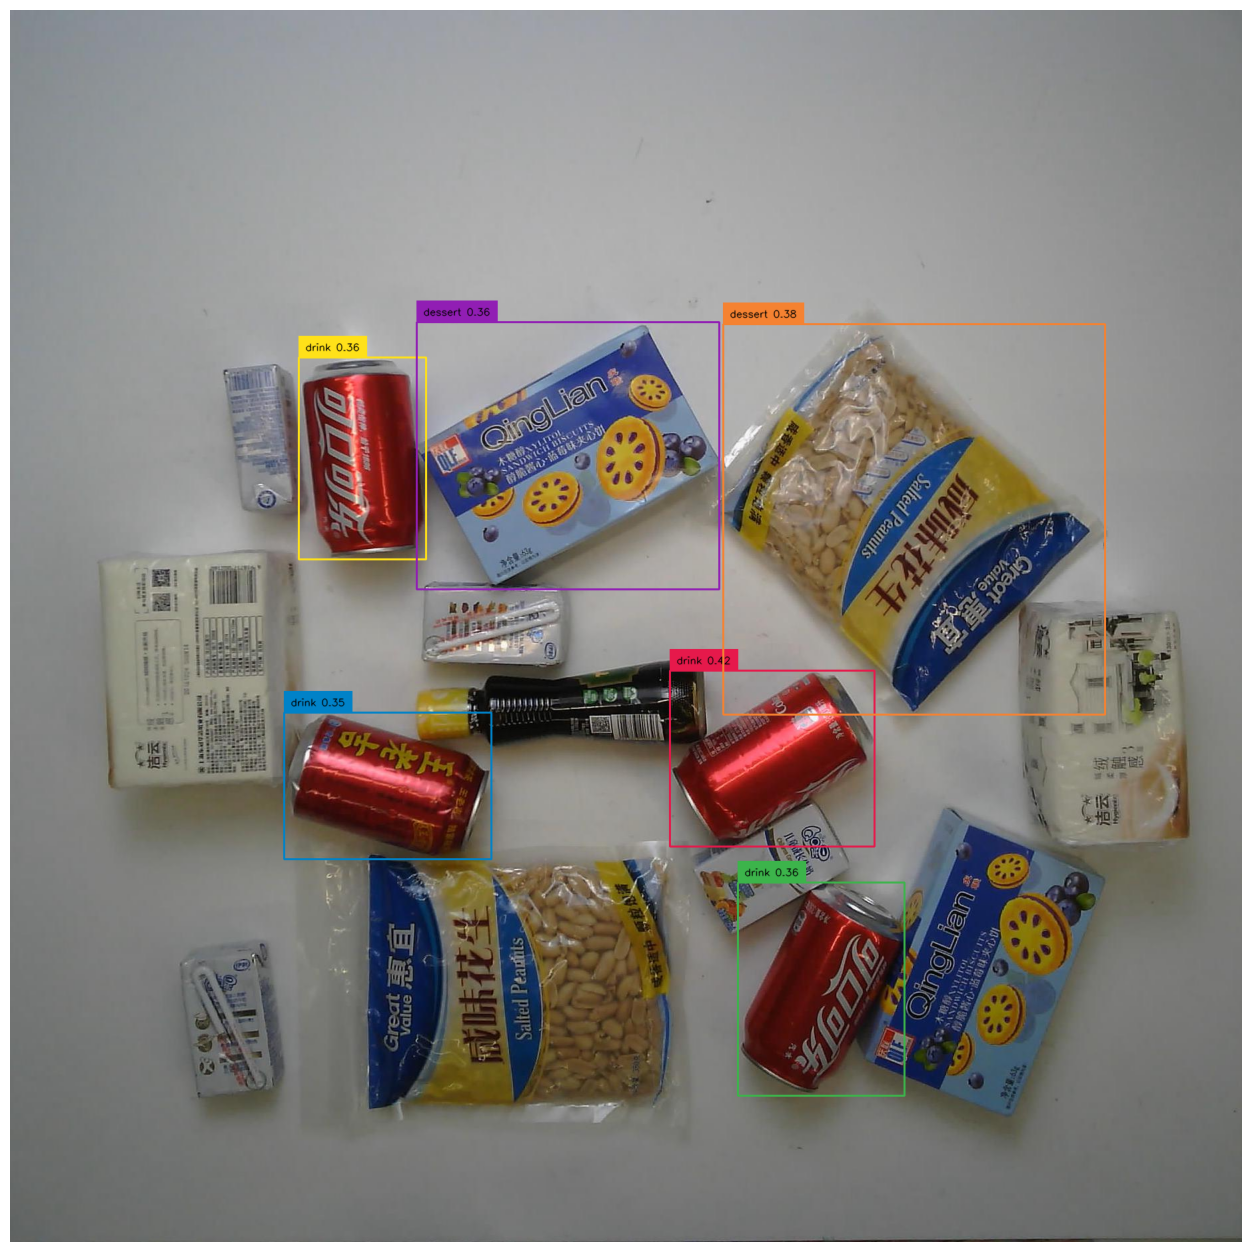

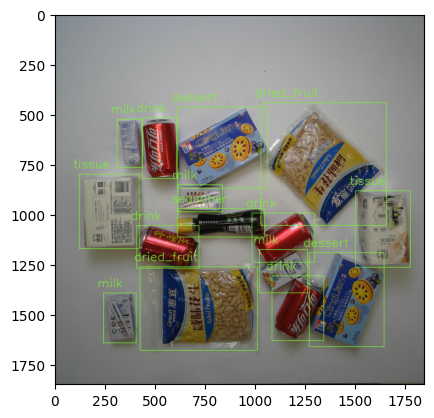

In [11]:
# one random example

from dataset.RPCDataset import RPCDataset

dataset_parent_dir = os.path.join(HOME, "RPCdataset/retail_product_checkout")
dataset = RPCDataset(dataset_parent_dir, "val")     # Split can be either train, val or test

n_imgs = dataset.get_num_imgs()
# print("Number of images: ", n_imgs)

# rand_ind = random.randint(0, n_imgs)
# rand_img_path = dataset.get_img_path_by_id(rand_ind)
# rand_img = dataset.get_img_by_id(rand_ind)
# annots = dataset.get_annots_by_img_id(rand_ind, "sku_class")
# for bbox, class_name in annots:

# annots = dataset.get_annots_by_img_id(rand_ind, "sku_class")    # ==> list of tuples
# print(list(set([annotation[1] for annotation in annots])))
# print([annotation[1] for annotation in annots])

# def pick_random_image(dataset: Dataset, subdirrectory: str = "valid") -> str:
#     image_directory_path = f"{dataset.location}/{subdirrectory}"
#     image_names = os.listdir(image_directory_path)
#     image_index = randrange(len(image_names))
#     image_name = image_names[image_index]
#     image_path = os.path.join(image_directory_path, image_name)
#     return image_path

TEXT_PROMPT = ''
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

# for ind in range(n_imgs):
for ind in range(4123,4124):
    img_path = dataset.get_img_path_by_id(ind)
    img_source, img = load_image(img_path)
    annots = dataset.get_annots_by_img_id(ind, "sku_class")    # ==> list of tuples
    classes = list(set([annotation[1] for annotation in annots]))
    TEXT_PROMPT = ', '.join(classes)
    boxes, logits, phrases = predict(
        model=model, 
        image=img, 
        caption=TEXT_PROMPT, 
        box_threshold=BOX_TRESHOLD, 
        text_threshold=TEXT_TRESHOLD
        )    
    
    annotated_frame = annotate(image_source=img_source, boxes=boxes, logits=logits, phrases=phrases)
    
    # plot pred img
    # predimg = plt.gcf()
    %matplotlib inline  
    sv.plot_image(annotated_frame, (16, 16))
    parent_directory = os.path.dirname(HOME)  # Get the parent directory
    imgsaving_folder_path = os.path.join(parent_directory, 'visualization')
    # predimg.savefig(os.path.join(imgsaving_folder_path, 'test_pred.jpg'))

    # plot gt img and save
    show_img = dataset.get_img_by_id(ind)
    vised_img = show_img.copy()
    for annot in annots:
        vised_img = vis_bbox_on_img(vised_img, annot[0], annot[1])  
    plt.figure()
    gtimg = plt.gcf()
    plt.imshow(vised_img)
    plt.show()  
    gtimg.savefig(os.path.join(imgsaving_folder_path, 'test_gt.jpg'))


In [94]:
%pip install -q roboflow dataclasses-json onemetric
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [12]:
# over whole dataset

import numpy as np
from tqdm import tqdm
from dataset.RPCDataset import RPCDataset
from onemetric.cv.object_detection import MeanAveragePrecision

dataset_parent_dir = os.path.join(HOME, "RPCdataset/retail_product_checkout")
dataset = RPCDataset(dataset_parent_dir, "val")     # Split can be either train, val or test

n_imgs = dataset.get_num_imgs()

TEXT_PROMPT = ''
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

gt, pred = [], []
count_class = []

for ind in tqdm(range(n_imgs)):   # --> mAP around 0.15
# for ind in tqdm(range(500)):    # --> mAP around 0.25
    img_path = dataset.get_img_path_by_id(ind)
    img_source, img = load_image(img_path)
    annots = dataset.get_annots_by_img_id(ind, "sku_class")    # ==> list of tuples
    gtboxes = [annotation[0] for annotation in annots]
    gtboxes = np.array(gtboxes)

    gtboxes[:, 2] = gtboxes[:, 0] + gtboxes[:, 2]  # x_max = top-left-x + width
    gtboxes[:, 3] = gtboxes[:, 1] + gtboxes[:, 3]  # y_max = top-left-y + height
    gtlabels = [annotation[1] for annotation in annots]
    gt_img = np.column_stack((gtboxes, gtlabels))

    width, height = img_source.shape[:2]
    
    prompts = list(set(gtlabels))
    TEXT_PROMPT = ','.join(prompts)
    TEXT_PROMPT = TEXT_PROMPT.replace('_', '')
    boxes, logits, phrases = predict(
        model=model, 
        image=img, 
        caption=TEXT_PROMPT, 
        box_threshold=BOX_TRESHOLD, 
        text_threshold=TEXT_TRESHOLD
        )    
    
    boxes = boxes.numpy()

    # Unnormalize the bounding boxes
    boxes[:, [0, 2]] *= height  # Multiply x-coordinates by width of the image
    boxes[:, [1, 3]] *= width  # Multiply y-coordinates by height of the image
    boxes[:, 0] = boxes[:, 0] - boxes[:, 2] / 2  # top-left-x = center-x - width / 2
    boxes[:, 1] = boxes[:, 1] - boxes[:, 3] / 2  # top-left-y = center-y - height / 2
    boxes[:, 2] = boxes[:, 0] + boxes[:, 2]  # x_max = top-left-x + width
    boxes[:, 3] = boxes[:, 1] + boxes[:, 3]  # y_max = top-left-y + height

    phrases = [s.replace(" ", "") for s in phrases]

    pred_img = np.column_stack((boxes, phrases, logits))

    if len(gt_img) > 0:
        gt_img[:, 4] = np.vectorize(lambda x: dataset.class_to_int.get(x.replace('_', ''), -1))(gt_img[:, 4])
        gt_img = gt_img.astype(np.float32)
    if len(pred_img) > 0:
        pred_img[:, 4] = np.vectorize(lambda x: dataset.class_to_int.get(x, -1))(pred_img[:, 4])
        pred_img = pred_img.astype(np.float32)

    gt.append(gt_img)
    pred.append(pred_img)


mean_average_precision = MeanAveragePrecision.from_detections(
    true_batches=gt, 
    detection_batches=pred, 
    num_classes=len(dataset.categories),
    iou_threshold=0.5
)

print("mAP =", mean_average_precision.value)



  0%|          | 0/500 [00:00<?, ?it/s]f:\ANACONDA\envs\dilab\lib\site-packages\transformers\modeling_utils.py:866: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
f:\ANACONDA\envs\dilab\lib\site-packages\torch\utils\checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 500/500 [02:21<00:00,  3.54it/s]


mAP = 0.24102531590820456


## Grounding DINO on COCO val 2017 Dataset

In [7]:
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple, Union, Optional
from dataclasses_json import dataclass_json
from supervision import Detections
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import sys
import torch
import torchvision


dataset_path = os.path.join(HOME, "dataset/COCO_dataset/val2017")
annot_file_name = 'instances_val2017.json'
annotation_path = os.path.join(HOME, "dataset/COCO_dataset/annotations", annot_file_name)

# read COCO annotations
coco = COCO(annotation_path)
img_ids = coco.getImgIds()
n_imgs = len(img_ids)
# get categorical info
categories = coco.loadCats(coco.getCatIds())
category_names = [category['name'] for category in categories]
TEXT_PROMPT = list(set(category_names))
TEXT_PROMPT = '.'.join(TEXT_PROMPT)
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

WEIGHTS_NAME = ["groundingdino_swinb_cogcoor.pth", "groundingdino_swint_ogc.pth"][1]
WEIGHTS_PATH = os.path.join(HOME, "external/GroundingDINO/weights", WEIGHTS_NAME)
CONFIG_PATH = os.path.join(HOME, "external\GroundingDINO\groundingdino\config\GroundingDINO_SwinT_OGC.py")

# os.path.join("F:\SS23\DILAB_project\SS2023_DI-Lab_Precitaste", "external\GroundingDINO\groundingdino\config\GroundingDINO_SwinB_cfg.py")

os.chdir(os.path.join(HOME, "external/GroundingDINO"))
sys.path.append(os.getcwd())
from groundingdino.util.inference import load_model, load_image, predict, annotate

model = load_model(CONFIG_PATH, WEIGHTS_PATH)

gt, pred = [], []

for id in tqdm(img_ids):  
# for id in tqdm(range(1)): 
    # id = img_ids[0]
    img_info = coco.loadImgs(id)[0]
    img_path = dataset_path + '/' + img_info['file_name']
    img_source, img = load_image(img_path)
    annot_ids = coco.getAnnIds(imgIds=img_info['id'])
    annotations = coco.loadAnns(annot_ids)
    
    # gtboxes, gtlabels = [], []
    # for annot in annotations:
    #     catid = annot['category_id']
    #     catinfo = coco.loadCats(catid)[0]
    #     label = catinfo['name']
    #     bbox = annot['bbox']
    #     gtboxes.append(bbox)
    #     gtlabels.append(label)
    #     gttest = torchvision.ops.boxes.box_convert(boxes=torch.from_numpy(gtboxes), in_fmt="xywh", out_fmt="xyxy").numpy()
    
    # extract label and bbox:
    gtboxes = np.array([annot['bbox'] for annot in annotations])
    if gtboxes.size != 0:
        gtboxes = torchvision.ops.boxes.box_convert(boxes=torch.from_numpy(gtboxes), in_fmt="xywh", out_fmt="xyxy").numpy()
    else:
        continue
    catids = [annot['category_id'] for annot in annotations]
    labels = [coco.loadCats(catid)[0]['name'] for catid in catids]
    gtlabels = np.array(labels)
    gt_img = np.column_stack((gtboxes, gtlabels))

    # pred
    boxes, logits, phrases = predict(   
    # tensor, tensor, list
        model=model, 
        image=img, 
        caption=TEXT_PROMPT, 
        box_threshold=BOX_TRESHOLD, 
        text_threshold=TEXT_TRESHOLD
        )    
    annotated_frame = annotate(image_source=img_source, boxes=boxes, logits=logits, phrases=phrases)
    # sv.plot_image(annotated_frame, (16, 16))
    # cv2.imwrite(os.path.join(output_dir, f'{ind}_gt.jpg'), annotated_frame)
    # boxes = boxes.numpy()

    h, w = img_source.shape[:2]
    boxes = boxes * torch.Tensor([w, h, w, h])
    if boxes.size != 0:
        boxes = torchvision.ops.boxes.box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()

    pred_img = np.column_stack((boxes, phrases, logits))

    class_to_int = {c: i for i, c in enumerate(category_names)}
    if len(gt_img) > 0:
        gt_img[:, 4] = np.vectorize(lambda x: class_to_int.get(x, -1))(gt_img[:, 4])
        gt_img = gt_img.astype(np.float32)
    if len(pred_img) > 0:
        pred_img[:, 4] = np.vectorize(lambda x: class_to_int.get(x, -1))(pred_img[:, 4])
        pred_img = pred_img.astype(np.float32)

    gt.append(gt_img)
    pred.append(pred_img)

mean_average_precision = MeanAveragePrecision.from_detections(
    true_batches=gt, 
    detection_batches=pred, 
    num_classes=len(category_names),
    iou_threshold=0.5
)

print("mAP =", mean_average_precision.value)


loading annotations into memory...
Done (t=1.22s)
creating index...
index created!
final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  0%|          | 0/5000 [00:00<?, ?it/s]f:\ANACONDA\envs\dilab\lib\site-packages\transformers\modeling_utils.py:866: FutureWarning: The `device` argument is deprecated and will be removed i

mAP = 0.5718676475567384
